# Exploratory Data Analysis

In [36]:
import fastai 
print(fastai.__version__)
import matplotlib 
from fastai.vision.all import *
# from fastai.vision.data import ImageBlock, CategoryBlock, parent_label, show_images
# from fastai.vision.augment import Resize
from fastai.metrics import accuracy, F1Score
matplotlib.rc('image', cmap='Greys')
from pathlib import Path
from fastai.data.all import *
# from fastai.data.block import DataBlock
# from fastai.data.transforms import RandomSplitter, get_image_files, first

from fastai.learner import Learner 
from fastai.interpret import ClassificationInterpretation

import numpy as np
import torch.nn as nn
import torch

2.7.15


## Load in the Data

### Specify Dataset
- Lung
    + Normal (n)
    + Adenocarcinomias (aca)
    + Squamous Cell Carcinomas (scc)
- Colon
    + Normal (n)
    + Adenocarcinomas (aca)

In [37]:
dset = 'lung' # 'lung' or 'colon'
path = (Path('../')/f'lung_colon_image_set/{dset}_image_sets')
Path.BASE_PATH = path
path.ls()

(#3) [Path('lung_aca'),Path('lung_n'),Path('lung_scc')]

### Create DataBlock
- Category Created from Parent Label
- Data is Image (2D) Data
- Use RandomSplitter for now for train/valid split
- Data Appears to be 768x768, but we can downsize to something smaller
- There is already an even split of cancer vs non cancer data so don't have to worry about being unbalanced

In [38]:
image_res = 256 # 256x256
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files, 
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(image_res))

In [39]:
db.summary(path)

Setting-up type transforms pipelines
Found 15000 items
2 datasets of sizes 12000,3000
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      ../lung_colon_image_set/lung_image_sets/lung_scc/lungscc125.jpeg
    applying PILBase.create gives
      PILImage mode=RGB size=768x768
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      ../lung_colon_image_set/lung_image_sets/lung_scc/lungscc125.jpeg
    applying parent_label gives
      lung_scc
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(2)

Final sample: (PILImage mode=RGB size=768x768, TensorCategory(2))


Found 15000 items
2 datasets of sizes 12000,3000
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na'

Create a dataloader from the DataBlock

In [40]:
dls = db.dataloaders(path, bs=32)

Print shape of first batch in validation set 
- 32 is the batch size
- 3 color channels
- 256 x 256 image is what we specified in DataBlock
- Descriptions: 
    + SCC looks like a sea of purple cells
    + ACA looks like there are white river channels along with a sea of purple cells
    + Normal (N) has a lot of empty white space and is colored with more red

torch.Size([32, 3, 256, 256])
torch.Size([32])


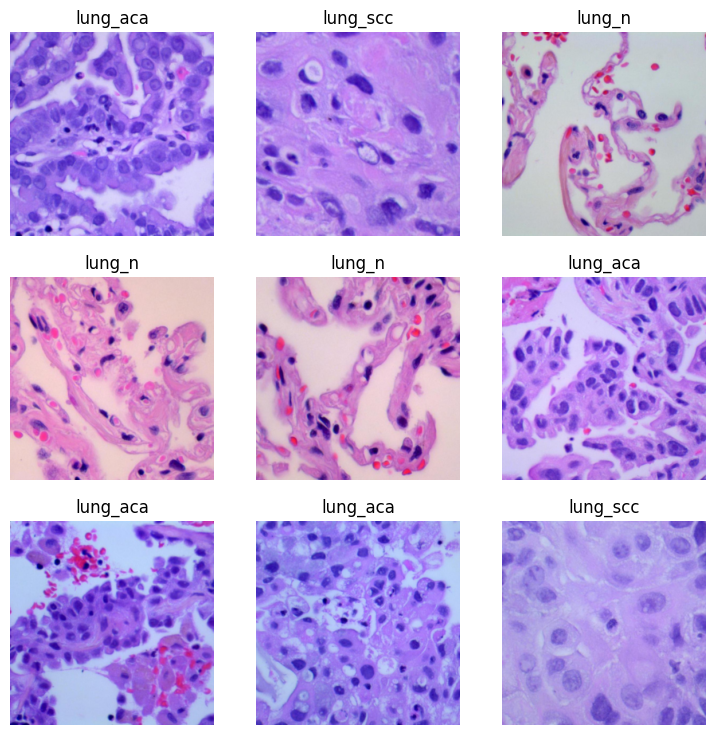

In [41]:
x, y = first(dls.train)
print(x.shape)
print(y.shape)
dls.show_batch()

## Define CNN Model
- 3 convolutional layers
- 3 ReLu activation and batch normalization
- Two Linear Dense Layers at the End

In [42]:
# Each Convolutional Block is a Conv2d layer followed by Batch Normalization, ReLU activation, and Max Pooling

class SimpleCNN(nn.Module):
    def __init__(self, nchannels=8):
        super(SimpleCNN, self).__init__()
        # 1st Convolutional Layer
        self.conv1 = nn.Conv2d(3, nchannels, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(nchannels)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 2nd Convolutional Layer
        self.conv2 = nn.Conv2d(nchannels, nchannels*2, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(nchannels*2)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 3rd Convolutional Layer
        self.conv3 = nn.Conv2d(nchannels*2, nchannels*4, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(nchannels*4)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully Connected Layer to Flatten Image
        self.fc1 = nn.Linear(nchannels*4 * int(image_res/8)**2, 128)
        self.actfc1 = nn.ReLU()
        
        # Fully Connected Output Layer for 3 Output Classes
        self.fc2 = nn.Linear(128, 3)
        

    def forward(self, x):
        x = self.pool1(self.act1(self.bn1(self.conv1(x))))
        x = self.pool2(self.act2(self.bn2(self.conv2(x))))
        x = self.pool3(self.act3(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.actfc1(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN()

## Fit One Cycle Training
- 10 Epochs
    + < 2 minutes per epoch
    + 'One Cycle' Warm-Up Period to find learning rate
- Flattened Cross Entropy Loss
- Keep Track of accuracy and F1 Score
- Seems like there's diminishing returns after 10 epochs
- F1 Score and Accuracy are identical (data has already been equally partitioned between different classes)

In [43]:
learn = Learner(dls, model, metrics=[accuracy, F1Score(average='macro')])
print(learn.loss_func)
learn.fit_one_cycle(10)

FlattenedLoss of CrossEntropyLoss()


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.256114,0.252650,0.916667,0.917783,01:57
1,0.218235,0.207077,0.914000,0.913550,01:59
2,0.176500,0.138353,0.947333,0.947433,01:59
3,0.145607,0.164365,0.935667,0.935735,01:57
4,0.091335,0.124214,0.953667,0.953744,01:58
5,0.036455,0.103810,0.965333,0.965326,01:59
6,0.020306,0.094454,0.968333,0.968339,01:56
7,0.007258,0.079183,0.975667,0.975666,01:46
8,0.002085,0.084305,0.976667,0.976698,01:46
9,0.001872,0.083336,0.976667,0.976699,01:45


## Summary of Model Architecture

In [44]:
learn.summary()

SimpleCNN (Input shape: 32 x 3 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 8 x 256 x 256  
Conv2d                                    608        True      
BatchNorm2d                               16         True      
ReLU                                                           
____________________________________________________________________________
                     32 x 8 x 128 x 128  
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 16 x 128 x 128 
Conv2d                                    1168       True      
BatchNorm2d                               32         True      
ReLU                                                           
____________________________________________________________________________
                     32 x 16 x 64 x 64   
MaxPool2d                                    

## Show Results

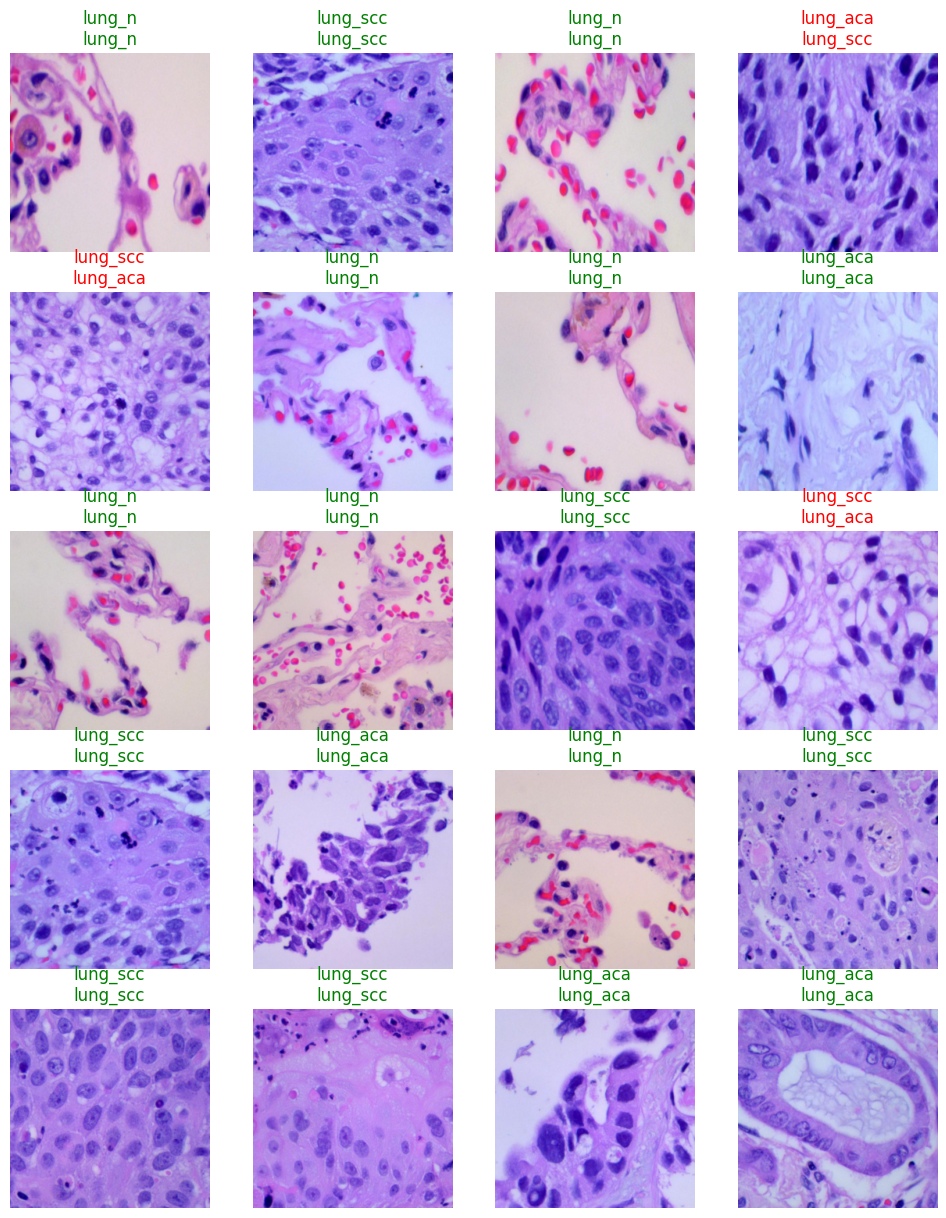

In [62]:
learn.show_results(max_n=20, nrows=5)

## Confusion Matrix
- Classification is being done on Validation set of 3000 images
- Whole Dataset is 15000 Images

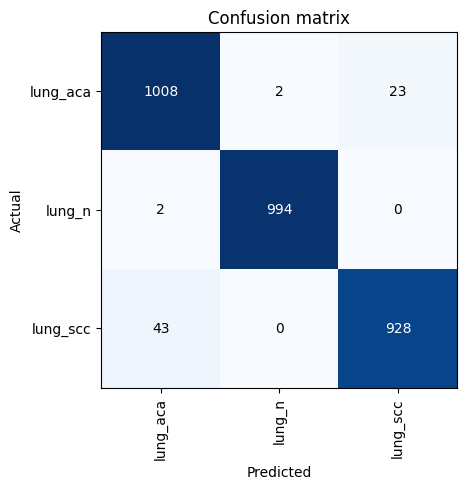

In [46]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## Show Top 5 predictions with highest error (largest loss)
- Confusion between SCC and ACA mostly

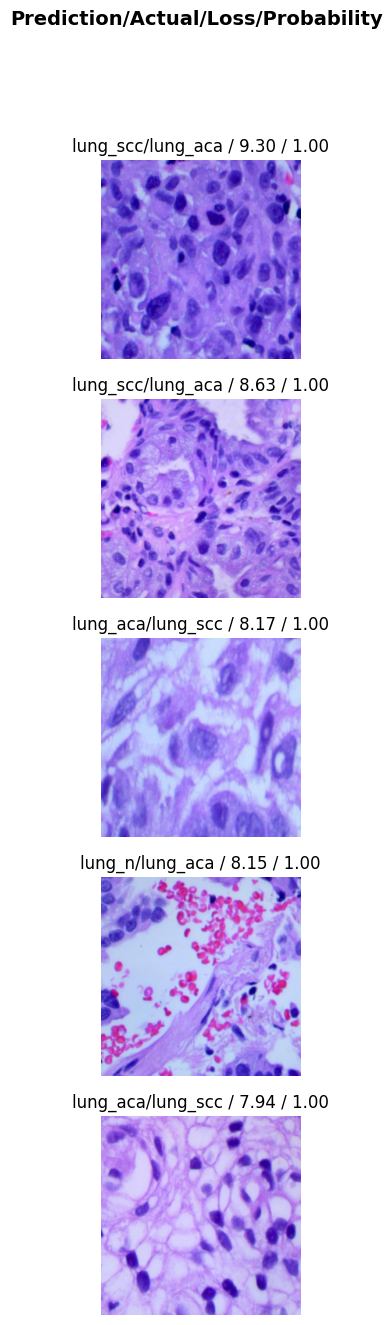

In [74]:
interp.plot_top_losses(5, nrows=5)